In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.all import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from catboost import  CatBoostRegressor

import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')






In [2]:
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
# # Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


In [14]:
data

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 20:00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 21:00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30


In [18]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')
weather.tail()
# Преобразуем даты
weather.loc[:, 'dt_iso']= pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.loc[:, ['dt_iso', 'temp']]
weather.head()

,dt_iso,temp
0,2015-01-01 00:00:00,270.475
1,2015-01-01 01:00:00,270.475
2,2015-01-01 02:00:00,269.686
3,2015-01-01 03:00:00,269.686
4,2015-01-01 04:00:00,269.686


In [19]:

# weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

weather

,temp
time,
2015-01-01 00:00:00,272.491463
2015-01-01 01:00:00,272.512700
2015-01-01 02:00:00,272.099137
2015-01-01 03:00:00,272.089469
2015-01-01 04:00:00,272.145900
...,...
2018-12-31 19:00:00,284.470000
2018-12-31 20:00:00,282.294000
2018-12-31 21:00:00,280.850000


In [20]:
data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')



In [22]:
data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp'],
      dtype='object')

In [26]:
data = data.loc[:, ['total load actual', 'price actual', "temp"]]
data = data.rename(columns={'total load actual': "target", 'price actual' : "price"})

In [29]:
data.tail(20)

,target,price,temp
time,,,
2018-12-31 04:00:00,20006.0,57.04,275.688
2018-12-31 05:00:00,20366.0,57.48,275.342
2018-12-31 06:00:00,21723.0,61.13,275.440
2018-12-31 07:00:00,23850.0,60.70,275.490
2018-12-31 08:00:00,25969.0,66.64,274.998
2018-12-31 09:00:00,28382.0,70.33,274.908
2018-12-31 10:00:00,29873.0,72.12,275.820
2018-12-31 11:00:00,29753.0,71.81,280.042
2018-12-31 12:00:00,28982.0,72.42,282.794


In [31]:
data = data.resample('D').mean()

In [32]:
data.isna().any().sum()

0

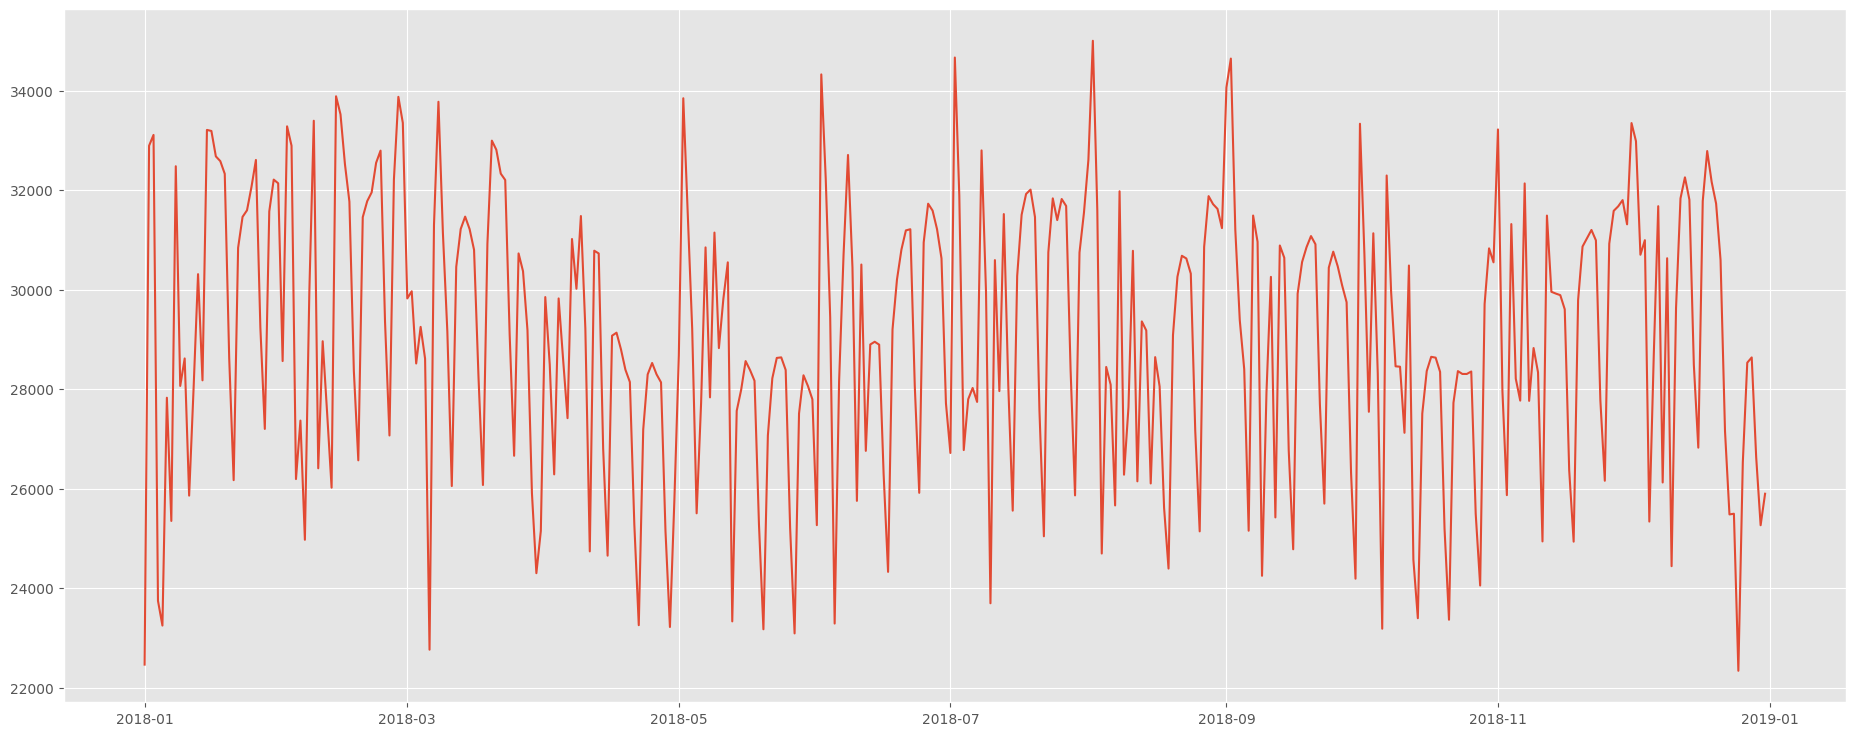

In [35]:
plt.plot(data.tail(365).target)

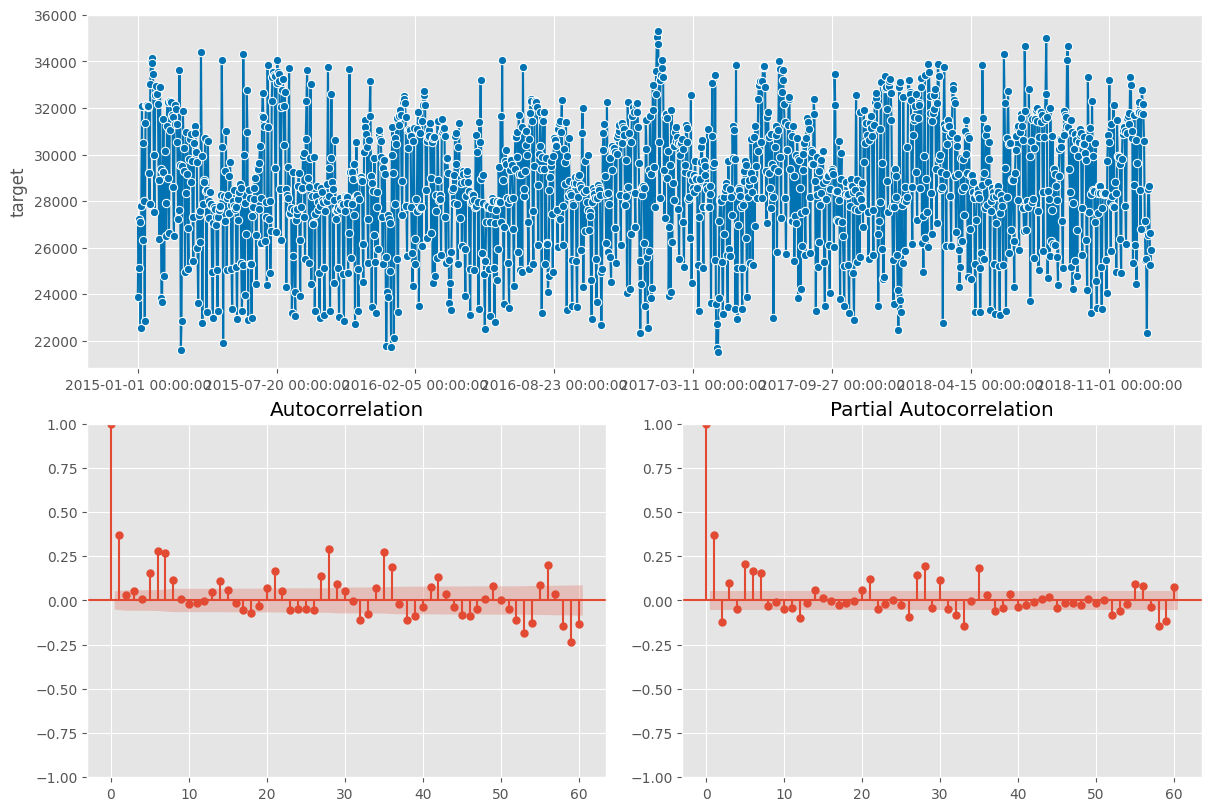

In [44]:
plot_correlations(data.target, lags=60);

In [84]:
import holidays

es_holidays = holidays.Spain()

dataset = data.copy()

dataset.loc[:, "target_L1"] = dataset.loc[:, "target"].shift()
dataset.loc[:, "target_L7"] = dataset.loc[:, "target"].shift(7)
dataset.loc[:, "target_diff_L1"] = dataset.loc[:, "target_L1"].diff()

dataset.loc[:, "price_L1"] = dataset.loc[:, "price"].shift()
dataset.loc[:, "price_diff_L1"] = dataset.loc[:, "price_L1"].diff()

dataset.loc[:, "target_rolling_mean_7"] = dataset.target.shift().rolling(7).mean()
dataset.loc[:, "target_rolling_mean_35"] = dataset.target.shift().rolling(35).mean()

dataset.loc[:, "price_rolling_mean_35"] = dataset.price.shift().rolling(35).mean()

dataset.loc[:, "temp_rolling_mean_7"] = dataset.temp.shift().rolling(7).mean()

t = np.arange(dataset.shape[0])
dataset.loc[:, "sin_6"] = np.sin((np.pi * 2 * t)/6)
dataset.loc[:, "cos_6"] = np.cos((np.pi * 2 * t)/6)

dataset.loc[:, "sin_7"] = np.sin((np.pi * 2 * t)/7)
dataset.loc[:, "cos_7"] = np.cos((np.pi * 2 * t)/7)

dataset.loc[:, "sin_365"] = np.sin((np.pi * 2 * t)/365)
dataset.loc[:, "cos_365"] = np.cos((np.pi * 2 * t)/365)

dataset.loc[:, 'is_holiday'] = data.index.to_series().apply(lambda x: x in es_holidays)
dataset.loc[:, 'is_yesterday_ holiday'] = (data.index - pd.DateOffset(days=1)).to_series().apply(lambda x: x in es_holidays).values
dataset.loc[:, 'is_tomorrow_holiday'] = (data.index + pd.DateOffset(days=1)).to_series().apply(lambda x: x in es_holidays).values

dataset = dataset.dropna()
dataset = dataset.drop(columns=["price"])

dataset.loc[:, 'is_weekend'] = dataset.index.weekday >= 5

y, X = dataset.loc[:, "target"], dataset.drop(columns="target")

cat_features = [
    'is_weekend',
    'is_holiday',
    'is_yesterday_ holiday',
    'is_tomorrow_holiday'
    ]

In [85]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)


In [86]:
model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)

In [87]:
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)

0.053034028178218943

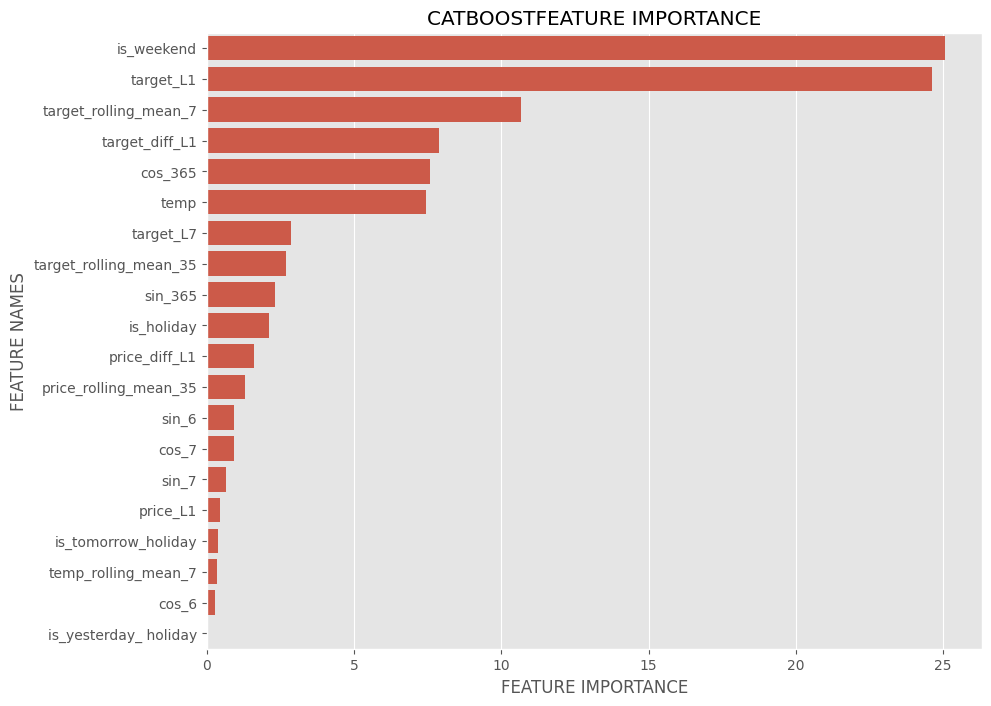

In [88]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),X.columns,'CATBOOST')

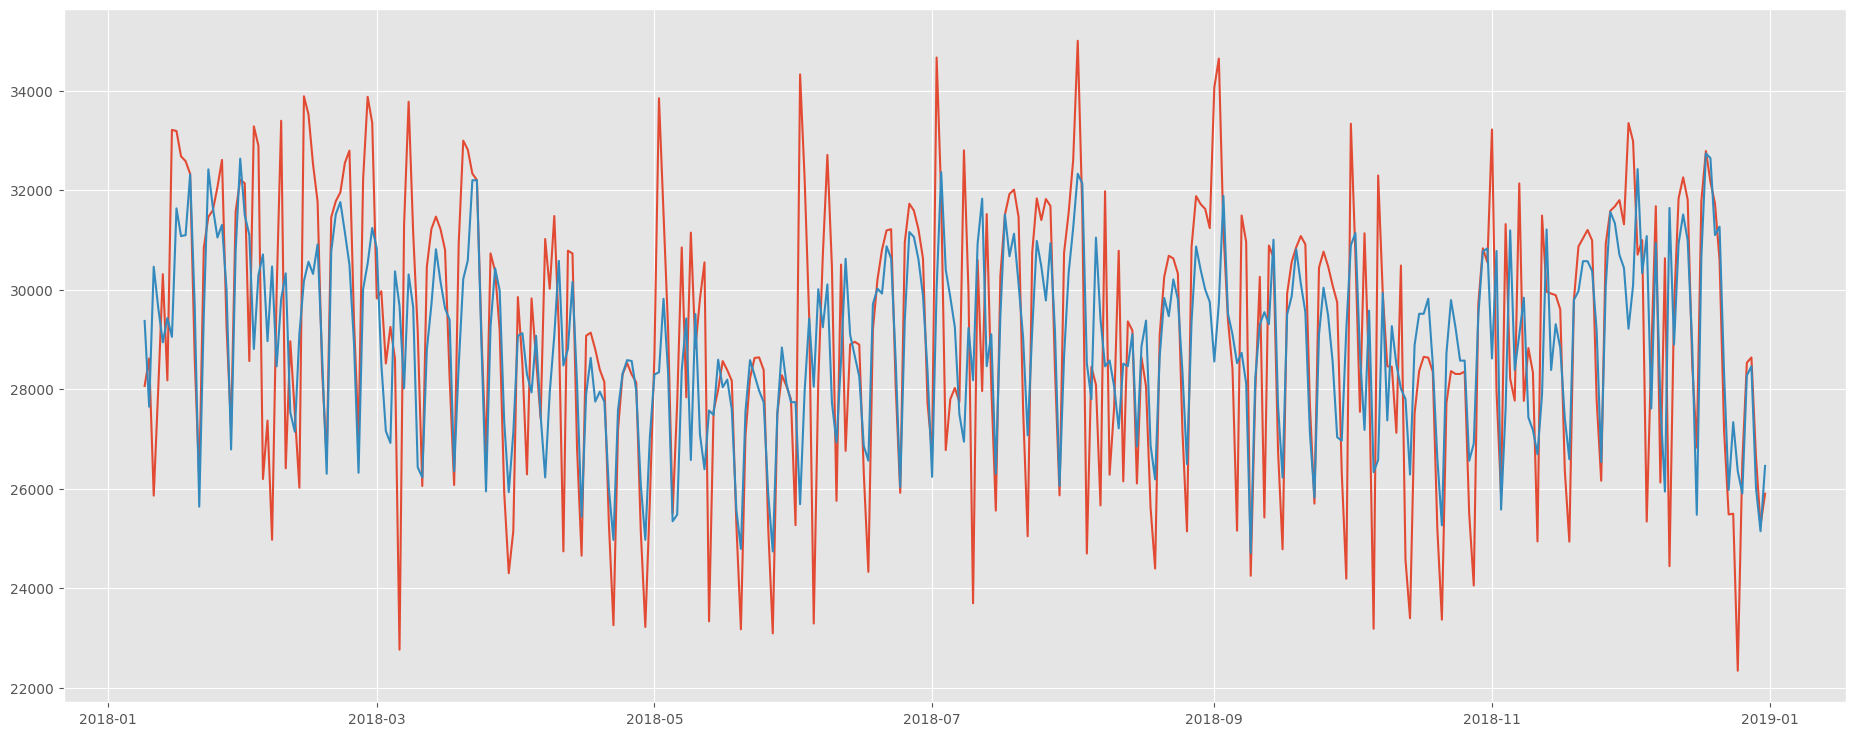

In [89]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)

In [91]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.05)

In [93]:
X_test.shape

(72, 20)

In [98]:
from tqdm import trange
models = []

max_horizon = X_test.shape[0]

for h in trange(1, max_horizon+1):

    if h == 1:
        y_train_cur = y_train.copy().iloc[h:].reset_index(drop=True)
        X_train_cur = X_train.copy().iloc[:-h].reset_index(drop=True)

    else:
        y_train_cur = y_train.iloc[h:].reset_index(drop=True)
        X_train_cur = X_train.iloc[:-h].reset_index(drop=True)
        
    assert len(X_train_cur) == len(y_train_cur), f"{len(X_train_cur)}, {len(y_train_cur)}"

    model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5)

    model.fit(X_train_cur, y_train_cur, cat_features=cat_features, verbose=0)

    models.append(model)

100%|██████████| 72/72 [00:02<00:00, 33.95it/s]


In [101]:
predictions = []

for model in models:
    predictions.append(
        model.predict(X_train.iloc[-1])
    )

In [103]:
from sktime.utils.plotting import plot_series

In [104]:
y_pred = pd.Series(predictions, index=y_test.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

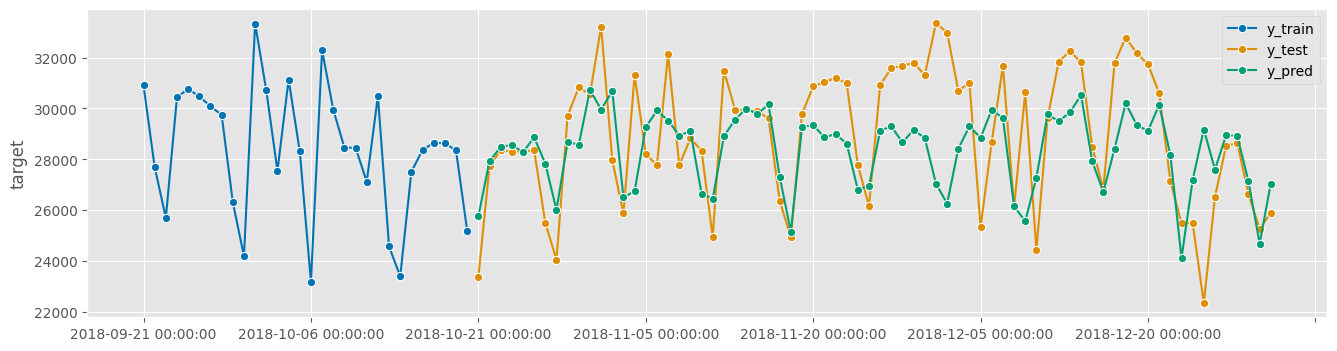

In [105]:
plot_series(y_train.tail(30), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [106]:
mean_absolute_percentage_error(y_pred, y_test)

0.06210318667115052